In [1]:
import pandas as pd
import numpy as np
import shap
#import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle


#from sklearn.metrics import r2_score
#from sklearn.model_selection import train_test_split
#from sklearn import preprocessing
#from sklearn.metrics import confusion_matrix

## Read in demographics file

In [2]:
df_dem = pd.read_csv("~/data/connectivityml/unrestricted_pkalra_7_26_2021_17_39_25.csv") 

In [3]:
df_dem.head()

,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100004,S900,Q06,M,22-25,False,0,0,0,0.0,...,5.2,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80
1,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
2,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
3,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
4,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88


In [4]:
print(df_dem.shape)
print(df_dem.columns.shape)

(1206, 582)
(582,)


### In the demographics file we found:

##### 1206 subjects
##### 582 demographics values

### Read in partial correlations connectivity file:

##### path to netmats2 for d100: data/connectivityml/HCP_PTN1200/netmats/3T_HCP1200_MSMAll_d100_ts2/netmats2.txt

In [5]:
df_conn_symm_d300 = pd.read_csv("~/data/connectivityml/HCP_PTN1200/netmats/3T_HCP1200_MSMAll_d300_ts2/netmats2.txt", sep=" ", header=None) 
df_conn_symm_d100 = pd.read_csv("~/data/connectivityml/HCP_PTN1200/netmats/3T_HCP1200_MSMAll_d100_ts2/netmats2.txt", sep=" ", header=None) 
df_conn_symm_d15 = pd.read_csv("~/data/connectivityml/HCP_PTN1200/netmats/3T_HCP1200_MSMAll_d15_ts2/netmats2.txt", sep=" ", header=None) 

In [6]:
print(df_conn_symm_d300.shape)
print(df_conn_symm_d100.shape)
print(df_conn_symm_d15.shape)

(1003, 90000)
(1003, 10000)
(1003, 225)


### In the connectivity files we found:

##### 1003 subjects
##### ICA 300: 300x300 = 90000 connectivity partial correlations
##### ICA 100: 100x100 = 10000 connectivity partial correlations
##### ICA 15: 15x15 = 225 connectivity partial correlations

In [7]:
#Code from Pradyumna to delete lower triangle of connectivity matrix

def pick_upper_triangle(df_conn_symm):
    p = df_conn_symm.shape[0]
    N = np.sqrt(df_conn_symm.shape[1]).astype(int)

    mat = np.transpose(df_conn_symm.values.reshape(p,N,N),[1,2,0])
    indx = np.triu_indices(N,1)
    mat2 = np.transpose(mat[indx],[1,0])
    print(mat2.shape)
    df_conn = pd.DataFrame(data=mat2)
    return df_conn, indx

In [8]:
df_conn_d300, indx_d300 = pick_upper_triangle(df_conn_symm_d300)
df_conn_d100, indx_d100 = pick_upper_triangle(df_conn_symm_d100)
df_conn_d15, indx_d15 = pick_upper_triangle(df_conn_symm_d15)

(1003, 44850)
(1003, 4950)
(1003, 105)


### Read in subject ID file:
##### --> want to make sure we filter the demographics and netmats file so that we only include shared participants
##### --> doc says that the netmats rows correspond to the subjectids in subjectIDs.txt (from Priya)

In [9]:
df_id = pd.read_csv("~/data/connectivityml/HCP_PTN1200/subjectIDs.txt", sep=" ", header=None) 
df_id.rename(columns={ df_id.columns[0]: "Subject" },inplace = True)

In [10]:
print(df_id.shape)
df_id.head()

(1003, 1)


,Subject
0,100206
1,100307
2,100408
3,100610
4,101006


### Create a new connectivity "triangle" files with subject IDs included:

In [11]:
df_conn_id_d300 = pd.concat([df_id, df_conn_d300], axis=1)
df_conn_id_d100 = pd.concat([df_id, df_conn_d100], axis=1)
df_conn_id_d15 = pd.concat([df_id, df_conn_d15], axis=1)

print(df_conn_id_d15.shape)
df_conn_id_d15.head()

(1003, 106)


,Subject,0,1,2,3,4,5,6,7,8,...,95,96,97,98,99,100,101,102,103,104
0,100206,-6.43160,2.9077,5.6367,-1.9108,-2.9030,-0.78089,1.6558,-0.46461,5.3488,...,-11.6960,6.3070,-1.0969,-5.1331,4.0238,-0.155880,5.8573,-2.14010,-2.723100,6.1086
1,100307,-4.09320,-4.8082,4.2359,1.2897,-6.0519,0.11149,-6.8054,-2.10540,2.7563,...,-14.8490,6.0243,-3.2385,-3.7186,1.5002,0.028649,1.4174,-0.93792,-2.052100,5.0104
2,100408,-0.15331,-4.4759,11.8270,-4.2061,-6.5727,-1.61310,-10.2110,-1.28100,2.0158,...,-7.7005,5.6862,2.2082,-3.5996,1.3614,2.315400,4.5837,-0.85564,-3.172500,4.0976
3,100610,-0.87383,-6.8278,10.1640,-1.8393,-9.1321,-2.86400,-7.2182,1.55410,2.2322,...,-8.1771,1.0031,-2.1297,-1.2231,3.2468,-1.501000,6.6318,-4.46040,-0.667030,7.3691
4,101006,-3.96500,2.5420,11.5050,-4.9034,-2.4797,3.18270,-4.2678,1.84570,5.9304,...,-7.0062,4.7975,-1.4163,-1.3990,7.0718,2.494300,8.1015,-0.66014,0.014264,1.4994


### Create new dem file with only netmats subjects, ordered in the same way:

In [12]:
df_dem_id= pd.merge_ordered(df_id, df_dem, left_by='Subject')
print(df_dem_id.shape)
df_dem_id.head()

(1003, 582)


,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
1,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
2,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
3,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
4,101006,S500,Q06,F,31-35,True,2,2,4,100.0,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80


### Now we have two types of files: df_conn_id_d* (netmats upper triangle info, 3x) and df_dem_id (demographics info, 1x)
##### - both only containing 1003 subjects shared between dem and netmats files
##### - both ordered the same way
##### - both with "Subject" as the first column

### We can start building ML models now! 
##### --> keep in mind that not all demographics values exist for all participants (some are na)
##### --> start with creating a function that can produce a x,y for a desired outcome that has lost all na rows for said outcome

In [13]:
#function to spit out x and y for ML models depending on what we want to predict
#filters out na values
def define_X_y(desired_y,conn_id,dem_id=df_dem_id):
    X = conn_id[dem_id[desired_y].notnull()].drop(['Subject'], axis=1)
    temp_y = dem_id[dem_id[desired_y].notnull()]
    y = temp_y[desired_y]
    print(X.shape)
    print(y.shape)
    return X,y

In [14]:
X_gend_d300 ,y_gend_d300 = define_X_y("Gender", df_conn_id_d300)
X_gend_d100 ,y_gend_d100 = define_X_y("Gender", df_conn_id_d100)
X_gend_d15 ,y_gend_d15 = define_X_y("Gender", df_conn_id_d15)

(1003, 44850)
(1003,)
(1003, 4950)
(1003,)
(1003, 105)
(1003,)


In [15]:
rf_d300 = RandomForestClassifier()
rf_d100 = RandomForestClassifier()
rf_d15 = RandomForestClassifier()

rf_d300.fit(X_gend_d300, y_gend_d300)
rf_d100.fit(X_gend_d100, y_gend_d100)
rf_d15.fit(X_gend_d15, y_gend_d15)

RandomForestClassifier()

### First we get the accuracy of our default classifier for the 3 ICA partitions:
##### --> use 5-fold cross-validation

In [16]:
r2_cv_d300 = cross_val_score(rf_d300, X_gend_d300, y_gend_d300, cv=5)
r2_cv_d100 = cross_val_score(rf_d100, X_gend_d100, y_gend_d100, cv=5)
r2_cv_d15 = cross_val_score(rf_d15, X_gend_d15, y_gend_d15, cv=5)

In [17]:
print(r2_cv_d300, "Average accuracy:", np.mean(r2_cv_d300))
print(r2_cv_d100, "Average accuracy:", np.mean(r2_cv_d100))
print(r2_cv_d15, "Average accuracy:", np.mean(r2_cv_d15))

[0.75621891 0.79104478 0.78606965 0.735      0.78      ] Average accuracy: 0.7696666666666665
[0.78109453 0.81094527 0.8159204  0.78       0.81      ] Average accuracy: 0.7995920398009949
[0.69651741 0.72636816 0.70149254 0.735      0.76      ] Average accuracy: 0.7238756218905472


In [18]:
X_gend_d15.shape

(1003, 105)

In [19]:
y_gend_d15.shape

(1003,)

### Compare SHAP analysis results for the 3 ICA partitions & see how much variation between folds there is:
##### Now we do 5-fold cross-validation by hand to look at how the most important features according to SHAP analysis change

In [20]:
def cross_val_with_shap(rf, X_gend, y_gend,cv=5):
    #randomize indices of subjects
    #in loop, reorder subjects, do partition into test/train, do shap plot, spit out top shap results
    
    X,y = shuffle(X_gend, y_gend)
    
    #comment out for sanity check that shuffling X,y independently leads to prediction no better than chance
    #X = shuffle(X_gend, random_state=2)
    #y = shuffle(y_gend, random_state=1)
    
    fold_size = np.floor_divide(y_gend.shape[0],cv)
    
    split_indices = []
    for i in range(1,cv):
        temp=fold_size*i
        split_indices.append(temp.astype(int))
    
    X_split = np.vsplit(X,split_indices)
    y_split = np.hsplit(y,split_indices)
    
    shap_values_cv = []

    for j in range(0,cv):
        train_indices = list(np.arange(5))
        train_indices.remove(j)
        
        X_test = X_split[j]
        X_train = [np.array(e) for i, e in enumerate(X_split) if i in train_indices]
        X_train = np.vstack(X_train)
        
        y_test = np.array(y_split[j])
        y_train = [np.array(e) for i, e in enumerate(y_split) if i in train_indices]
        y_train = np.hstack(y_train)
        
        rf = RandomForestClassifier()
        rf.fit(X_train,y_train)
        train_acc = rf.score(X_train, y_train)
        test_acc = rf.score(X_test, y_test)
        
        print(test_acc)
        
        shap_values = shap.TreeExplainer(rf).shap_values(X_train)
        shap.summary_plot(shap_values, X_train)
        shap_values_cv.append(shap_values)
        
    return shap_values_cv

0.71


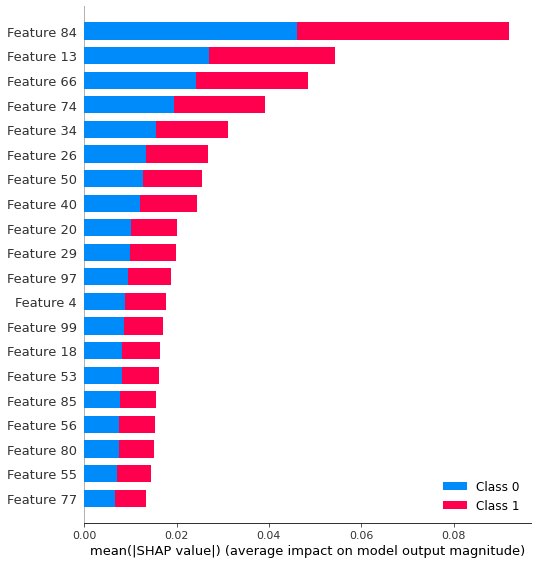

0.785


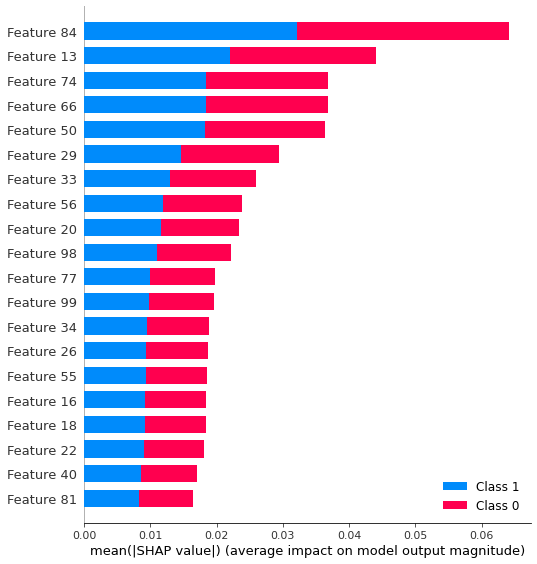

0.71


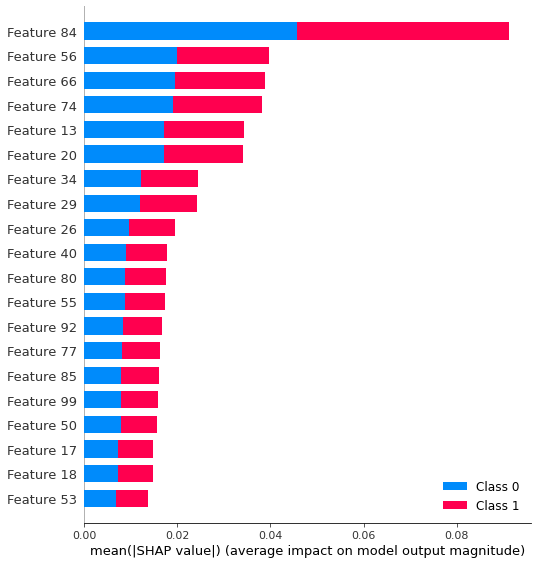

0.72


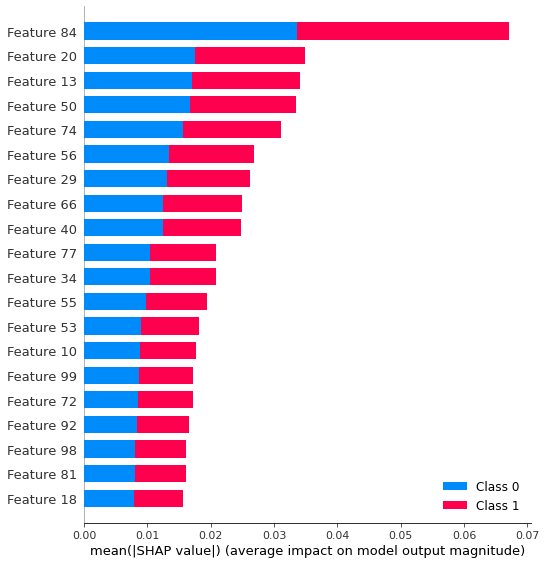

0.7389162561576355


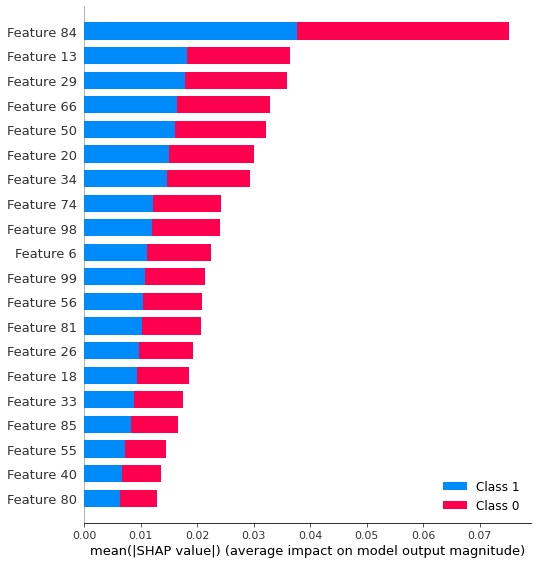

In [21]:
shap_values_cv = cross_val_with_shap(rf_d15,X_gend_d15,y_gend_d15)

0.745


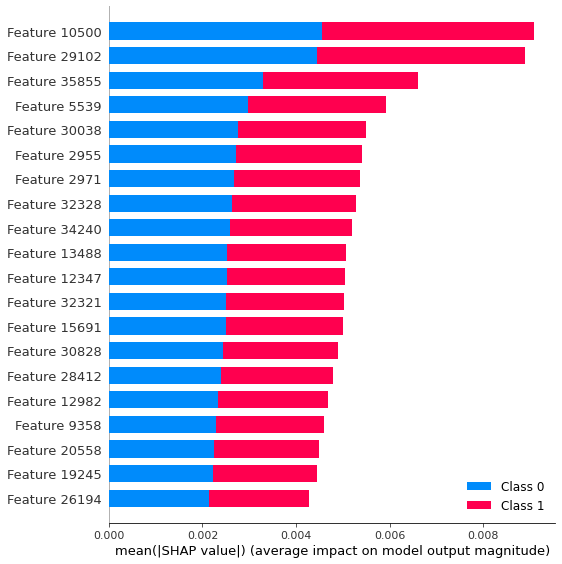

0.85


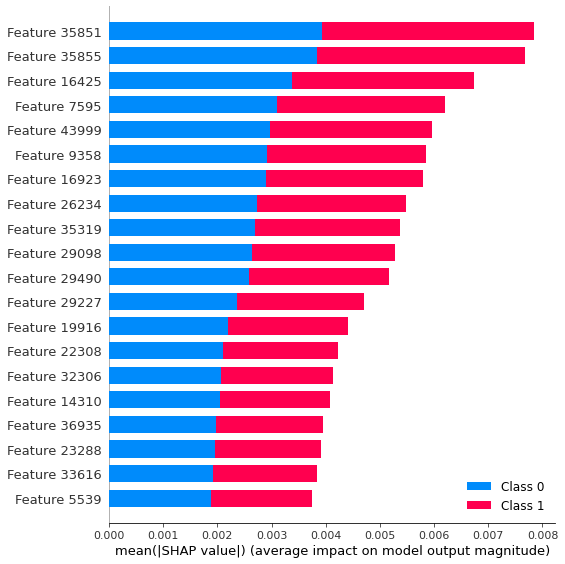

0.785


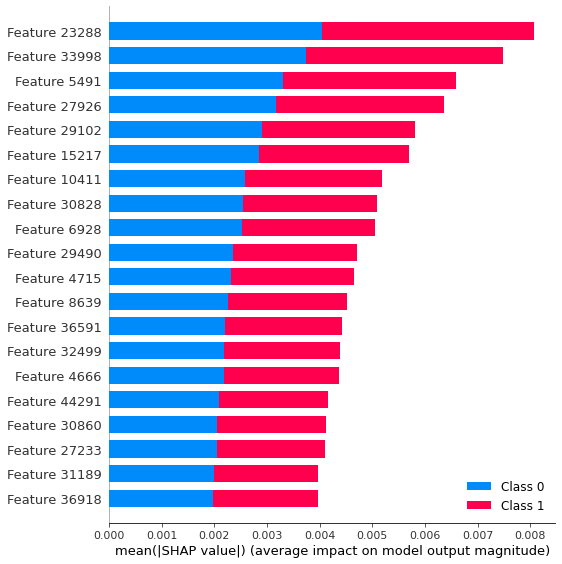

0.765


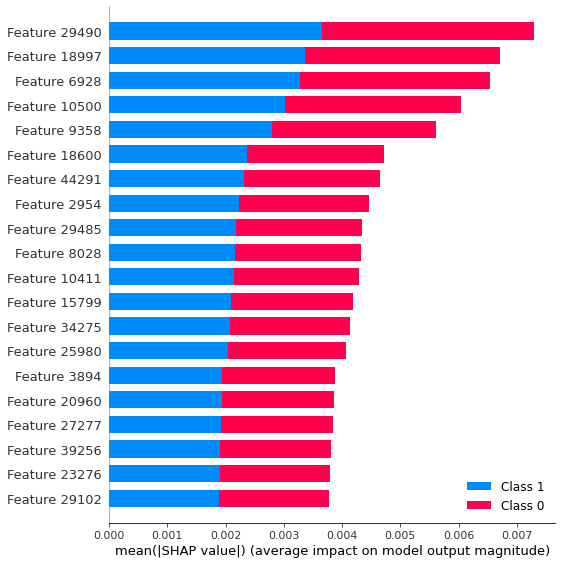

0.7536945812807881


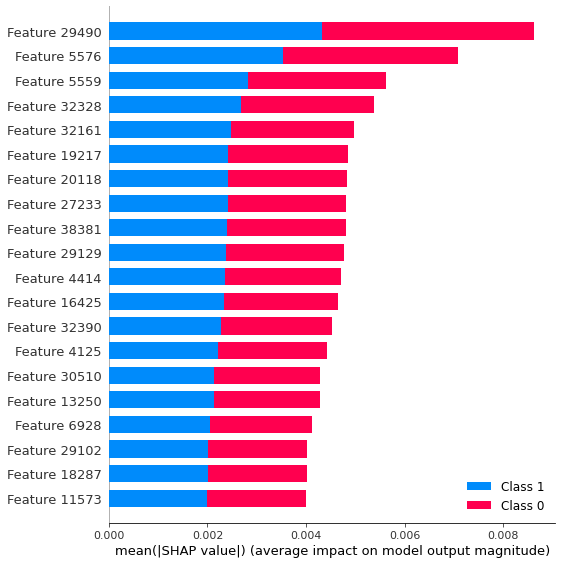

In [22]:
shap_values_cv = cross_val_with_shap(rf_d300,X_gend_d300,y_gend_d300)

In [23]:
X_gend_d300.shape

(1003, 44850)

In [24]:
print(indx_d300[0][43928])
print(indx_d300[1][43928])

256
281


In [25]:
print(indx_d300[0][5350])
print(indx_d300[1][5350])

18
140


In [26]:
print(indx_d300[0][9358])
print(indx_d300[1][9358])

33
53


In [27]:
print(indx_d300[0][9404])
print(indx_d300[1][9404])

33
99


In [28]:
print(indx_d300[0][32328])
print(indx_d300[1][32328])

141
181


In [29]:
print(indx_d15[0][84])
print(indx_d15[1][84])

8
9
